# 利用压缩感知原理进行采样时压缩

目前我的工作要对三相电流电压进行采样。要实现高精度采样，通常需要用高采样率。但是，高采样率会导致数据量增加，给数据存储和处理造成很大压力。特别是在需要长时间采样的情况下，传统方法可能存储不了这么多数据。还有，对于使用嵌入式设备进行边缘端采样的应用，嵌入式设备的存储空间本来就有限，这一问题就更严重了。

压缩感知是一种信号处理技术，用于高效地获取和重构信号，通过寻找欠定线性系统的解。此技术基于一个原理，即一个具有稀疏表示的信号可以从远少于传统方法使用的样本或测量中恢复。

压缩感知理论为解决这一问题提供了一种有效的方案。通过利用信号在频域的稀疏性，压缩感知理论可以实现较低采样率下的信号重构。经过测试，利用压缩感知方法可以利用10%的数据就能重建出原始信号。也就是说，如果存储空间仅支持高频采样100秒，利用压缩感知技术可以将采样时间提高到1000秒。

In [6]:
import pandas as pd

def load_csv(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename, index_col='index')
    return df.iloc[22:-15]

df = load_csv('data/30Hz-35Nm-1ms.csv')
print(df)

             i_a        i_b        i_c         u_a         u_b  di_1  di_2
index                                                                     
23     21.385193 -18.287659  -3.379822  489.477875  592.547119     0     0
24     18.638611 -20.202637   1.235962  482.404480  639.837708     0     0
25     16.593933 -22.155762   5.332947  487.456909  696.323669     0     0
26     13.351440 -23.483276   9.841919  506.959229  755.234863     0     0
27      9.124756 -22.903442  13.504028  531.817078  811.417664     0     0
...          ...        ...        ...         ...         ...   ...   ...
953    15.609741   6.401062 -21.972656  742.502747  506.555023     0     0
954    18.226624   2.578735 -20.896912  683.591614  490.286255     0     0
955    20.988464  -1.976013 -19.195557  629.530762  489.578918     0     0
956    22.163391  -6.515503 -15.922546  585.877930  497.763824     0     0
957    22.468567 -10.208130 -12.527466  544.650208  511.910583     0     0

[935 rows x 7 columns]


x dimension: 935


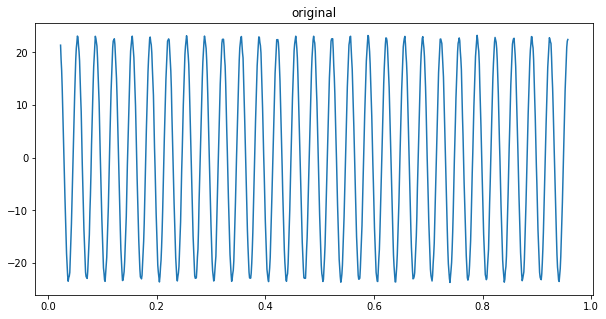

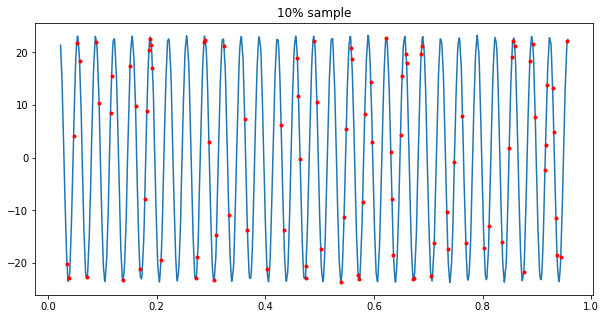

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 11 02:29:38 PM: Your problem has 935 variables, 1 constraints, and 0 parameters.
(CVXPY) May 11 02:29:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 02:29:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 02:29:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 02:29:38 PM: Compiling problem (target solver=ECOS).
(CVXPY) May 11 02:29:38 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

c:\users\administrator\appdata\local\programs\python\python38\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


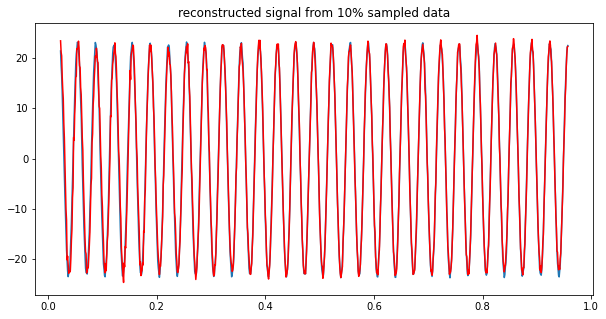

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import cvxpy as cvx

plt.rcParams['figure.figsize'] = [10, 5]

def compressed_sensing(t: np.ndarray, y: np.ndarray):
    n = len(y)
    print(f"x dimension: {len(y)}")
    plt.plot(t, y)
    plt.title('original')
    plt.show()

    yt = spfft.dct(y, norm='ortho')
    # extract small sample of signal
    sample_n = n // 10  # 10% sample
    ri = np.random.choice(n, sample_n, replace=False) # random sample of indices
    ri.sort()
    t2 = t[ri]
    y2 = y[ri]

    plt.plot(t, y)
    plt.plot(t2, y2, 'r.')
    plt.title('10% sample')
    plt.show()

    # create idct matrix operator
    A = spfft.idct(np.identity(n), norm='ortho', axis=0)
    A = A[ri]

    # do L1 optimization
    vx = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [A*vx == y2]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(verbose=True)

    # reconstruct signal
    x = np.array(vx.value)
    x = np.squeeze(x)
    sig = spfft.idct(x, norm='ortho', axis=0)

    plt.plot(t, y)
    plt.plot(t, sig, 'r-')
    plt.title('reconstructed signal from 10% sampled data')
    plt.show()

compressed_sensing(df.index.values/1000, df['i_a'].values)

可以看到，利用压缩感知方法可以利用10%的数据就能重建出原始信号。